## 模型

In [1]:
import os
import math
from abc import abstractmethod

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
!pip install einops>=0.4
!pip install einops-exts

zsh:1: 0.4 not found


In [3]:
from einops import rearrange
from einops.layers.torch import Rearrange
from einops_exts import rearrange_many, repeat_many

In [11]:
class Identity(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

    def forward(self, x, *args, **kwargs):
        return x
    
    
class LayerNorm(nn.Module):
    def __init__(self, feats, stable = True, dim = -1):
        super().__init__()
        self.stable = stable
        self.dim = dim

        self.g = nn.Parameter(torch.ones(feats, *((1,) * (-dim - 1))))

    def forward(self, x):
        dtype, dim = x.dtype, self.dim
        if self.stable:
            x = x / x.amax(dim = dim, keepdim = True).detach()
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = dim, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = dim, keepdim = True)
        return (x - mean) * (var + eps).rsqrt().type(dtype) * self.g.type(dtype)

    
class Always():
    def __init__(self, val):
        self.val = val

    def __call__(self, *args, **kwargs):
        return self.val


In [12]:
def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    Args:
        timesteps (Tensor): a 1-D Tensor of N indices, one per batch element. These may be fractional.
        dim (int): the dimension of the output.
        max_period (int, optional): controls the minimum frequency of the embeddings. Defaults to 10000.

    Returns:
        Tensor: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, t, y):
        """
        Apply the module to `x` given `t` timestep embeddings, `y` conditional embedding same shape as t.
        """
        pass


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that support it as an extra input.
    """

    def forward(self, x, t, y):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, t, y)
            else:
                x = layer(x)
        return x

    
def norm_layer(channels):
    return nn.GroupNorm(32, channels)


class Block(nn.Module):
    def __init__(
        self,
        dim,
        dim_out,
        groups = 8,
        norm = True
    ):
        super().__init__()
        self.groupnorm = nn.GroupNorm(groups, dim) if norm else Identity()
        self.activation = nn.SiLU()
        self.project = nn.Conv2d(dim, dim_out, kernel_size=3, padding = 1)

    def forward(self, x, scale_shift = None):
        x = self.groupnorm(x)

        if scale_shift is not None:
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.activation(x)
        return self.project(x)


class CrossAttention(nn.Module):
    def __init__(
        self,
        dim,
        *,
        context_dim = None,
        dim_head = 64,
        heads = 8,
        norm_context = False,
        cosine_sim_attn = False
    ):
        super().__init__()
        self.scale = dim_head ** -0.5 if not cosine_sim_attn else 1.
        self.cosine_sim_attn = cosine_sim_attn
        self.cosine_sim_scale = 16 if cosine_sim_attn else 1

        self.heads = heads
        inner_dim = dim_head * heads

        context_dim = dim if context_dim is None else context_dim

        self.norm = LayerNorm(dim)
        self.norm_context = LayerNorm(context_dim) if norm_context else Identity()

        self.null_kv = nn.Parameter(torch.randn(2, dim_head))
        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim, bias = False),
            LayerNorm(dim)
        )

    def forward(self, x, context):
        b, n, device = *x.shape[:2], x.device
        x = self.norm(x)
        context = self.norm_context(context)
        q, k, v = (self.to_q(x), *self.to_kv(context).chunk(2, dim = -1))
        q, k, v = rearrange_many((q, k, v), 'b n (h d) -> b h n d', h = self.heads)
        # add null key / value for classifier free guidance in prior net
        nk, nv = repeat_many(self.null_kv.unbind(dim = -2), 'd -> b h 1 d', h = self.heads,  b = b)
        k = torch.cat((nk, k), dim = -2)
        v = torch.cat((nv, v), dim = -2)
        q = q * self.scale
        # similarities
        sim = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.cosine_sim_scale
        # masking
        max_neg_value = -torch.finfo(sim.dtype).max
        attn = sim.softmax(dim = -1, dtype = torch.float32)
        attn = attn.to(sim.dtype)
        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)
    
    
class GlobalContext(nn.Module):
    """ basically a superior form of squeeze-excitation that is attention-esque """

    def __init__(
        self,
        *,
        dim_in,
        dim_out
    ):
        super().__init__()
        self.to_k = nn.Conv2d(dim_in, 1, 1)
        hidden_dim = max(3, dim_out // 2)

        self.net = nn.Sequential(
            nn.Conv2d(dim_in, hidden_dim, 1),
            nn.SiLU(),
            nn.Conv2d(hidden_dim, dim_out, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        context = self.to_k(x)
        x, context = rearrange_many((x, context), 'b n ... -> b n (...)')
        out = torch.einsum('b i n, b c n -> b c i', context.softmax(dim = -1), x)
        out = rearrange(out, '... -> ... 1')
        return self.net(out)
    
class ResidualBlock(TimestepBlock):
    def __init__(self, dim_in, dim_out, time_dim, dropout, use_global_context=False, groups = 8):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(dim_in),
            nn.SiLU(),
            nn.Conv2d(dim_in, dim_out, kernel_size=3, padding=1)
        )

        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim, dim_out*2)
        )

        self.conv2 = nn.Sequential(
            norm_layer(dim_out),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, padding=1)
        )

        self.block1 = Block(dim_in, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)

        if dim_in != dim_out:
            self.shortcut = nn.Conv2d(dim_in, dim_out, kernel_size=1)
        else:
            self.shortcut = nn.Identity()
        cond_dim = time_dim
        self.gca = GlobalContext(dim_in = dim_out, dim_out = dim_out) if use_global_context else Always(1)
        self.cross_attn = CrossAttention(dim = dim_out, context_dim = cond_dim,)

    def forward(self, x, t, y):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        `y` has shape `[batch_size, num_time_tokens, cond_dim]`
        """
        h = self.block1(x)
        
        # Add time step embeddings
        context = y
#         print("h.shape", h.shape, "x.shape", x.shape, "context.shape", context.shape, "t.shape", t.shape, "y.shape", y.shape)
        size = h.size(-2)
        hidden = rearrange(h, 'b c h w -> b (h w) c')
        attn = self.cross_attn(hidden, context)
#         print("attn.shape", attn.shape)
        attn = rearrange(attn, 'b (h w) c -> b c h w', h=size)
        h += attn
        
        t = self.time_emb(t)
        t = rearrange(t, 'b c -> b c 1 1')
        scale_shift = t.chunk(2, dim = 1)
        h = self.block2(h, scale_shift=scale_shift)
        
        h *= self.gca(h)
        return h + self.shortcut(x)

    
class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        """
        Attention block with shortcut

        Args:
            channels (int): channels
            num_heads (int, optional): attention heads. Defaults to 1.
        """
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0

        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B*self.num_heads, -1, H*W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x

    
class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

    
class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(stride=2)

    def forward(self, x):
        return self.op(x)

    
    
class UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding
    """
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4,
        label_num=10,
        num_time_tokens = 2,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads

        # time embedding
        time_embed_dim = model_channels * 4
        cond_dim = time_embed_dim
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )
        self.label_embedding = nn.Embedding(label_num, time_embed_dim)
        self.to_time_tokens = nn.Sequential(
            nn.Linear(time_embed_dim, num_time_tokens * cond_dim),
            Rearrange('b (r d) -> b r d', r = num_time_tokens)
        )

        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2

        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout)
        )

        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, t, y):
        """Apply the model to an input batch.

        Args:
            x (Tensor): [N x C x H x W]
            t (Tensor): a 1-D batch of timesteps.
            y (Tensor): [N x 1] LongTensor conditional

        Returns:
            Tensor: [N x C x ...]
        """
        # time step embedding
        t = self.time_embed(timestep_embedding(t, self.model_channels))
        y = self.label_embedding(y)
        y = self.to_time_tokens(y)

        hs = []
        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, t, y)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, t, y)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, t, y)
        return self.out(h)

    
def linear_beta_schedule(timesteps):
    """
    beta schedule
    """
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas

        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev)
            / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))

        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev)
            / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )

    def _extract(self, a, t, x_shape):
        # get the param of given timestep t
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out

    def q_sample(self, x_start, t, noise=None):
        # forward diffusion (using the nice property): q(x_t | x_0)
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def q_mean_variance(self, x_start, t):
        # Get the mean and variance of q(x_t | x_0).
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def q_posterior_mean_variance(self, x_start, x_t, t):
        # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def predict_start_from_noise(self, x_t, t, noise):
        # compute x_0 from x_t and pred noise: the reverse of `q_sample`
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def p_mean_variance(self, model, x_t, t, y, clip_denoised=True):
        # compute predicted mean and variance of p(x_{t-1} | x_t)
        # predict noise using model
        pred_noise = model(x_t, t, y)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, model, x_t, t, y, clip_denoised=True):
        # denoise_step: sample x_{t-1} from x_t and pred_noise
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t, y, clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img

    @torch.no_grad()
    def p_sample_loop(self, model, y, shape):
        # denoise: reverse diffusion
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            t = torch.full((batch_size,), i, device=device, dtype=torch.long)
            img = self.p_sample(model, img, t, y)
            imgs.append(img.cpu().numpy())
        return imgs

    @torch.no_grad()
    def sample(self, model, y, image_size, batch_size=8, channels=3):
        # sample new images
        return self.p_sample_loop(model, y, shape=(batch_size, channels, image_size, image_size))

    def train_losses(self, model, x_start, t, y):
        # compute train losses
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t, y)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

看看效果

In [5]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

%matplotlib inline

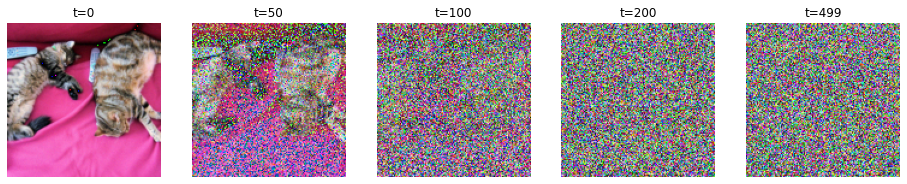

In [6]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)
# image = Image.open("/data/000000039769.jpg")

image_size = 128
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

x_start = transform(image).unsqueeze(0)

gaussian_diffusion = GaussianDiffusion(timesteps=500)

plt.figure(figsize=(16, 8))
for idx, t in enumerate([0, 50, 100, 200, 499]):
    x_noisy = gaussian_diffusion.q_sample(x_start, t=torch.tensor([t]))
    noisy_image = (x_noisy.squeeze().permute(1, 2, 0) + 1) * 127.5
    noisy_image = noisy_image.numpy().astype(np.uint8)
    plt.subplot(1, 5, 1 + idx)
    plt.imshow(noisy_image)
    plt.axis("off")
    plt.title(f"t={t}")

## 训练

准备数据集

In [7]:
batch_size = 64
timesteps = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

模型

In [13]:
# define model and diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[],
    label_num=len(dataset.classes)
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

开始训练

In [14]:
epochs = 10
losses = []
for epoch in range(epochs):
    for step, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        batch_size = images.shape[0]
        images = images.to(device)
        labels = labels.to(device)

        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = gaussian_diffusion.train_losses(model, images, t, labels)

        if step % 200 == 0:
            print("Epoch:", epoch, "Loss:", loss.item())
        losses += [loss.item()]

        loss.backward()
        optimizer.step()

Loss: 1.3348678350448608
Loss: 0.037579216063022614
Loss: 0.03557509183883667
Loss: 0.022273221984505653
Loss: 0.02380727231502533
Loss: 0.032583482563495636
Loss: 0.02113409899175167
Loss: 0.02352892979979515
Loss: 0.021378900855779648
Loss: 0.024902915582060814
Loss: 0.022534871473908424
Loss: 0.018547171726822853
Loss: 0.02209225855767727
Loss: 0.027315692976117134
Loss: 0.031540729105472565
Loss: 0.025797750800848007
Loss: 0.021289879456162453
Loss: 0.02685999870300293
Loss: 0.0177988912910223
Loss: 0.02424127608537674
Loss: 0.019753215834498405
Loss: 0.015379379503428936
Loss: 0.023044439032673836
Loss: 0.025185540318489075
Loss: 0.020594391971826553
Loss: 0.017560681328177452
Loss: 0.027322961017489433
Loss: 0.016609540209174156
Loss: 0.01934245601296425
Loss: 0.013710318133234978
Loss: 0.02854449674487114
Loss: 0.013989710249006748
Loss: 0.019418399780988693
Loss: 0.027105756103992462
Loss: 0.023523012176156044
Loss: 0.022412000223994255
Loss: 0.031093290075659752
Loss: 0.014371

In [ ]:
!pip install pyecharts

In [15]:
import pyecharts.options as opts
from pyecharts.charts import Line

(
    Line()
    .add_xaxis(list(range(len(losses))))
    .add_yaxis(
        "Loss",
        losses,
        markpoint_opts=opts.MarkPointOpts(data=[
            opts.MarkPointItem(type_="min"),
            opts.MarkPointItem(type_="max"),
        ]),
    )
    .set_global_opts(title_opts=opts.TitleOpts(title="Loss"))
    .render_notebook()
)

NameError: name 'losses' is not defined

## 测试

In [18]:
batch_size=64
y = torch.randint(0,10, (batch_size,)).cuda()
generated_images = gaussian_diffusion.sample(model, y, 28,batch_size=batch_size, channels=1)
# generated_images: [timesteps, batch_size=64, channels=1, height=28, width=28]

sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:46<00:00, 10.68it/s]


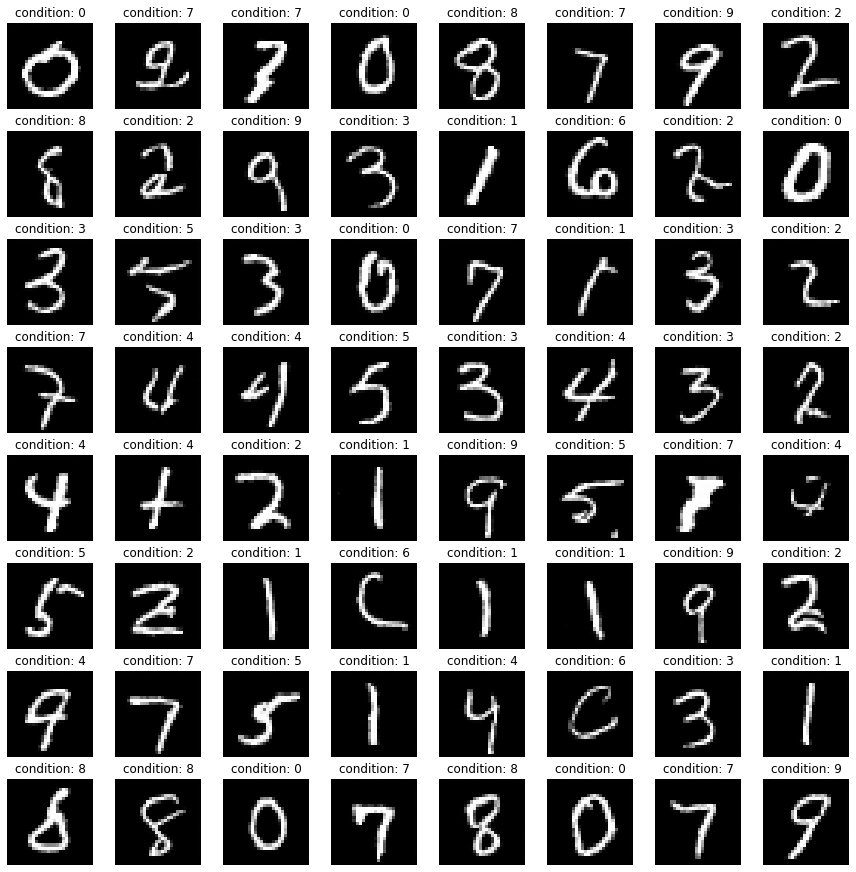

In [36]:
# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")
        plt.title(f"condition: {y[n_row*8+n_col]}")

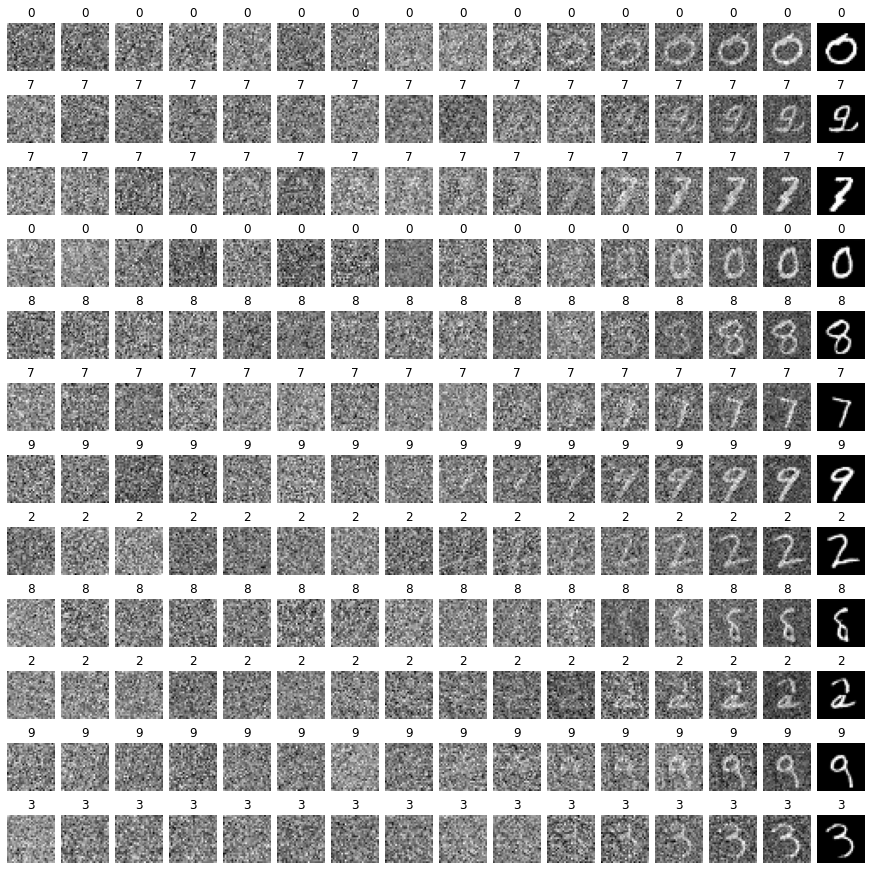

In [40]:
# show the denoise steps
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
rows = 12 #len(y)
gs = fig.add_gridspec(rows, 16)
for n_row in range(rows):
    for n_col in range(16):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        t_idx = (timesteps // 16) * n_col if n_col < 15 else -1
        img = generated_images[t_idx][n_row].reshape(28, 28)
        f_ax.imshow((img+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")
        plt.title(f"{y[n_row]}")